In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print("Starting inference pipeline for BigMart Sales Prediction...")


Starting inference pipeline for BigMart Sales Prediction...


In [2]:
def load_inference_data():
    """Load all necessary data and models for inference"""
    
    # Load preprocessed test data
    X_test = pd.read_csv('processed_data/test_cleaned.csv')
    test_ids = pd.read_csv('processed_data/test_ids.csv')
    
    # Load preprocessing objects
    label_encoders = joblib.load('models/label_encoders.pkl')
    scaler = joblib.load('models/scaler.pkl')
    outlier_bounds = joblib.load('models/outlier_bounds.pkl')
    
    # Load trained model
    best_model = joblib.load('models/best_model.pkl')
    
    print(f"Test data shape: {X_test.shape}")
    print(f"Test IDs shape: {test_ids.shape}")
    print(f"Model loaded: {type(best_model).__name__}")
    print(f"Encoders loaded: {len(label_encoders)} categorical features")
    
    return X_test, test_ids, label_encoders, scaler, outlier_bounds, best_model

X_test, test_ids, encoders, scaler, outlier_bounds, model = load_inference_data()


Test data shape: (5681, 16)
Test IDs shape: (5681, 2)
Model loaded: XGBRegressor
Encoders loaded: 8 categorical features


In [3]:
# Validate data consistency
print("Data validation:")
print(f"Missing values in test data: {X_test.isnull().sum().sum()}")
print(f"Test data dtypes:")
print(X_test.dtypes)

# Check for any infinite or NaN values
print(f"\nInfinite values in test data: {np.isinf(X_test.select_dtypes(include=[np.number])).sum().sum()}")

# Display basic statistics
print("\nTest data summary:")
display(X_test.describe())


Data validation:
Missing values in test data: 5681
Test data dtypes:
Item_Weight                  float64
Item_Fat_Content             float64
Item_Visibility              float64
Item_Type                    float64
Item_MRP                     float64
Outlet_Establishment_Year    float64
Outlet_Size                  float64
Outlet_Location_Type         float64
Outlet_Type                  float64
Item_Category                float64
Outlet_Years                 float64
Item_Visibility_MeanRatio    float64
Item_Type_Combined           float64
Price_per_Unit_Weight        float64
Outlet_Type_Size             float64
Item_Outlet_Sales            float64
dtype: object

Infinite values in test data: 0

Test data summary:


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Category,Outlet_Years,Item_Visibility_MeanRatio,Item_Type_Combined,Price_per_Unit_Weight,Outlet_Type_Size,Item_Outlet_Sales
count,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5.681000e+03,5681.000000,5681.000000,5681.000000,0.0
mean,-0.043186,0.007846,-0.015556,0.001598,0.000490,-0.000354,0.000031,-0.000048,0.000192,0.012058,0.000354,3.126838e-18,0.011009,0.025048,0.000116,NaN
std,1.002720,0.998666,0.983830,1.002212,0.992576,1.000118,1.000006,1.000140,1.000411,0.999983,1.000118,9.118876e-01,1.001418,1.013161,1.000241,NaN
min,-1.790638,-0.997813,-1.392895,-1.716656,-1.750447,-1.532846,-2.128115,-1.369334,-1.508289,-2.095286,-1.334103,-1.812793e+00,-2.208395,-1.377572,-1.810542,NaN
25%,-0.916696,-0.997813,-0.811705,-0.766479,-0.748028,-1.293934,-0.664080,-1.369334,-0.252658,-0.179795,-0.736822,-5.982207e-01,-0.219369,-0.716103,-0.428061,NaN
50%,-0.112713,0.119565,-0.252465,-0.291391,0.006787,0.139541,0.799954,-0.138882,-0.252658,-0.179795,-0.139541,-9.671889e-03,-0.219369,-0.212760,0.263179,NaN
75%,0.823653,1.236942,0.572531,0.658786,0.723186,0.736822,0.799954,1.091569,-0.252658,-0.179795,1.293934,1.106230e-02,-0.219369,0.469313,0.263179,NaN
max,1.824595,1.236942,2.726538,1.846507,2.016907,1.334103,0.799954,1.091569,2.258603,1.735696,1.532846,3.249461e+00,1.769656,4.733701,1.645660,NaN


In [7]:
X_test.pop('Item_Outlet_Sales')

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
5676   NaN
5677   NaN
5678   NaN
5679   NaN
5680   NaN
Name: Item_Outlet_Sales, Length: 5681, dtype: float64

In [8]:
X_test.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Category,Outlet_Years,Item_Visibility_MeanRatio,Item_Type_Combined,Price_per_Unit_Weight,Outlet_Type_Size
0,1.695442,-0.997813,-1.309483,1.371418,-0.532035,0.139541,-0.664080,-1.369334,-0.252658,-0.179795,-0.139541,-0.599729,-0.219369,-0.937353,-0.428061
1,-0.984502,1.236942,-0.661595,-0.766479,-0.861920,1.095190,0.799954,-0.138882,-0.252658,-0.179795,-1.095190,0.027391,-0.219369,-0.274174,0.263179
2,0.371614,0.119565,0.622038,0.896330,1.618094,0.020085,0.799954,1.091569,-1.508289,1.735696,-0.020085,2.425617,1.769656,0.478188,-1.810542
3,-1.196530,-0.997813,-1.145247,1.371418,0.225484,1.095190,0.799954,-0.138882,-0.252658,-0.179795,-1.095190,0.031631,-0.219369,1.055792,0.263179
4,0.156357,1.236942,1.021408,-0.766479,1.497272,-1.532846,-0.664080,1.091569,2.258603,-0.179795,1.532846,-0.025718,-0.219369,0.560965,1.645660


In [9]:
def make_predictions(X_test, model):
    """Make predictions on test data"""
    print("Making predictions on test data...")
    
    # Generate predictions
    predictions = model.predict(X_test)
    
    # Ensure predictions are positive (sales cannot be negative)
    predictions = np.maximum(predictions, 0)
    
    print(f"Predictions generated: {len(predictions)}")
    print(f"Prediction statistics:")
    print(f"  Mean: {np.mean(predictions):.2f}")
    print(f"  Median: {np.median(predictions):.2f}")
    print(f"  Std: {np.std(predictions):.2f}")
    print(f"  Min: {np.min(predictions):.2f}")
    print(f"  Max: {np.max(predictions):.2f}")
    
    return predictions

# Make predictions
test_predictions = make_predictions(X_test, model)


Making predictions on test data...
Predictions generated: 5681
Prediction statistics:
  Mean: 2180.46
  Median: 2050.60
  Std: 1200.18
  Min: 240.79
  Max: 5889.32


In [10]:
def create_submission(test_ids, predictions, filename='submission.csv'):
    """Create submission file in required format"""
    
    submission = pd.DataFrame({
        'Item_Identifier': test_ids['Item_Identifier'],
        'Outlet_Identifier': test_ids['Outlet_Identifier'],
        'Item_Outlet_Sales': predictions
    })
    
    # Save submission file
    submission.to_csv(filename, index=False)
    
    print(f"Submission file created: {filename}")
    print(f"Submission shape: {submission.shape}")
    print(f"\nFirst 5 rows of submission:")
    display(submission.head())
    
    # Verify format matches sample submission
    print(f"\nSubmission file validation:")
    print(f"  Required columns: Item_Identifier, Outlet_Identifier, Item_Outlet_Sales")
    print(f"  Actual columns: {list(submission.columns)}")
    print(f"  Number of predictions: {len(submission)}")
    
    return submission

# Create submission file
submission_df = create_submission(test_ids, test_predictions)


Submission file created: submission.csv
Submission shape: (5681, 3)

First 5 rows of submission:


,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1667.500977
1,FDW14,OUT017,1406.344727
2,NCN55,OUT010,683.247986
3,FDQ58,OUT017,2461.337646
4,FDY38,OUT027,5696.907715



Submission file validation:
  Required columns: Item_Identifier, Outlet_Identifier, Item_Outlet_Sales
  Actual columns: ['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']
  Number of predictions: 5681


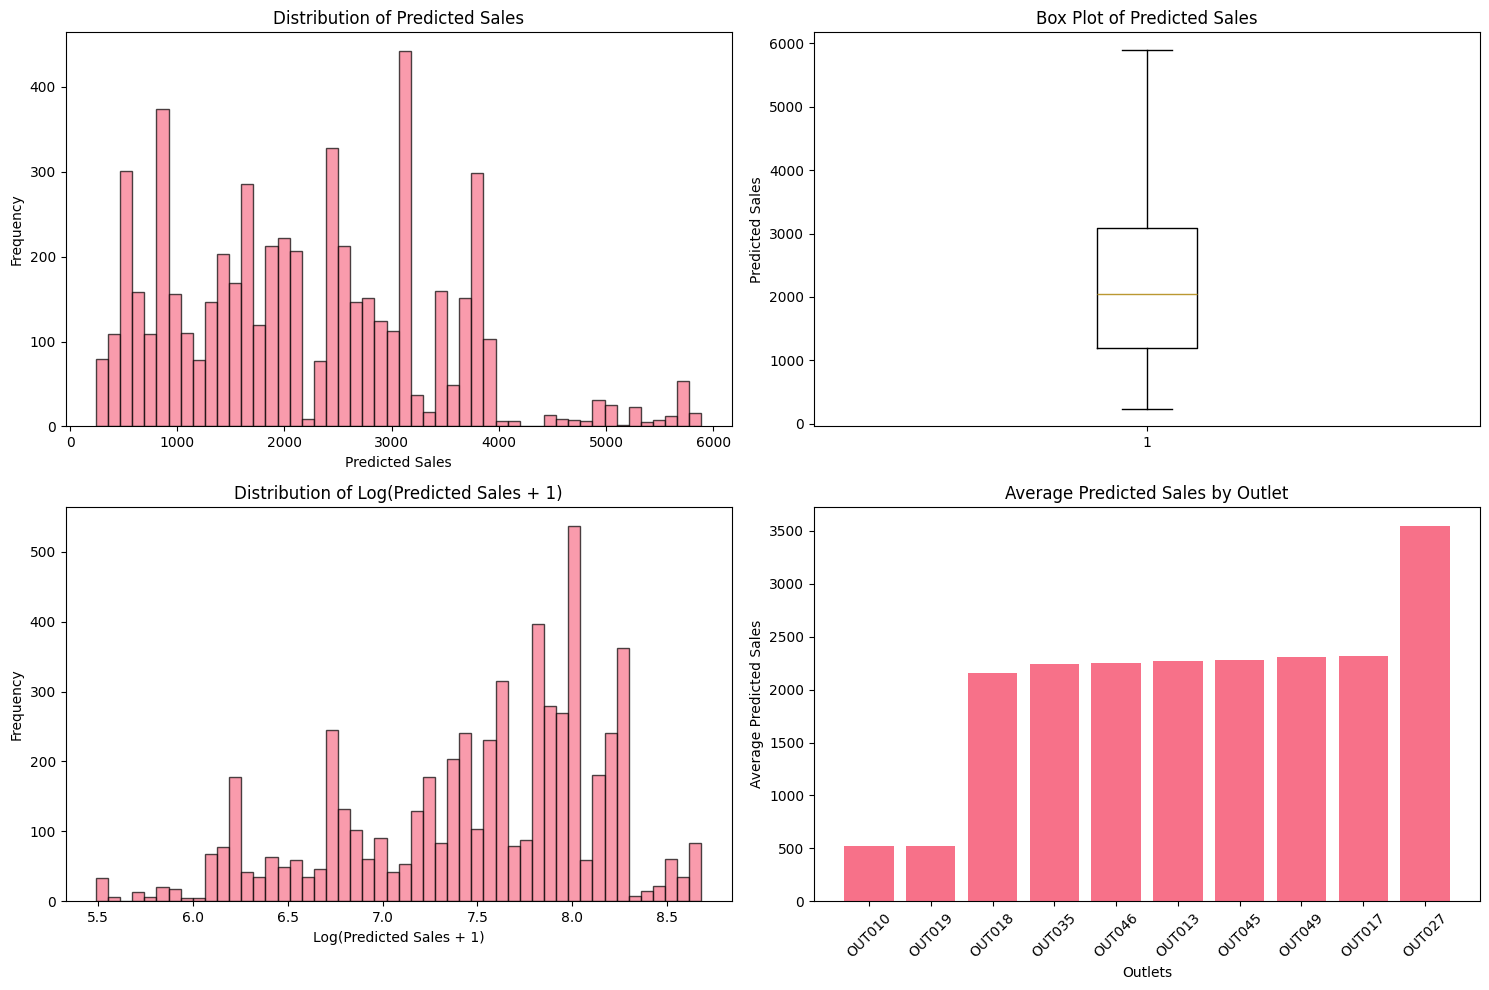

In [11]:
# Visualize prediction distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram of predictions
axes[0, 0].hist(test_predictions, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Predicted Sales')
axes[0, 0].set_xlabel('Predicted Sales')
axes[0, 0].set_ylabel('Frequency')

# Box plot of predictions
axes[0, 1].boxplot(test_predictions)
axes[0, 1].set_title('Box Plot of Predicted Sales')
axes[0, 1].set_ylabel('Predicted Sales')

# Log-scale histogram
axes[1, 0].hist(np.log1p(test_predictions), bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Log(Predicted Sales + 1)')
axes[1, 0].set_xlabel('Log(Predicted Sales + 1)')
axes[1, 0].set_ylabel('Frequency')

# Predictions by outlet
if 'Outlet_Identifier' in test_ids.columns:
    outlet_predictions = pd.DataFrame({
        'Outlet_Identifier': test_ids['Outlet_Identifier'],
        'Predicted_Sales': test_predictions
    })
    outlet_means = outlet_predictions.groupby('Outlet_Identifier')['Predicted_Sales'].mean().sort_values()
    
    axes[1, 1].bar(range(len(outlet_means)), outlet_means.values)
    axes[1, 1].set_title('Average Predicted Sales by Outlet')
    axes[1, 1].set_xlabel('Outlets')
    axes[1, 1].set_ylabel('Average Predicted Sales')
    axes[1, 1].set_xticks(range(len(outlet_means)))
    axes[1, 1].set_xticklabels(outlet_means.index, rotation=45)

plt.tight_layout()
plt.show()


In [12]:
# Additional analysis
print("Detailed Prediction Analysis:")
print("=" * 50)

# Percentiles
percentiles = [5, 10, 25, 50, 75, 90, 95]
print("Prediction Percentiles:")
for p in percentiles:
    value = np.percentile(test_predictions, p)
    print(f"  {p}th percentile: {value:.2f}")

# Predictions by outlet type (if available in test_ids)
print(f"\nPredictions by Outlet:")
outlet_stats = pd.DataFrame({
    'Outlet_Identifier': test_ids['Outlet_Identifier'],
    'Predicted_Sales': test_predictions
}).groupby('Outlet_Identifier')['Predicted_Sales'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)

display(outlet_stats)

# Check for extreme predictions
extreme_low = test_predictions < np.percentile(test_predictions, 1)
extreme_high = test_predictions > np.percentile(test_predictions, 99)

print(f"\nExtreme Predictions:")
print(f"  Very low predictions (< 1st percentile): {extreme_low.sum()}")
print(f"  Very high predictions (> 99th percentile): {extreme_high.sum()}")

if extreme_low.sum() > 0:
    print(f"  Lowest predictions: {test_predictions[extreme_low][:5]}")
if extreme_high.sum() > 0:
    print(f"  Highest predictions: {test_predictions[extreme_high][:5]}")


Detailed Prediction Analysis:
Prediction Percentiles:
  5th percentile: 490.73
  10th percentile: 626.79
  25th percentile: 1188.44
  50th percentile: 2050.60
  75th percentile: 3080.20
  90th percentile: 3773.51
  95th percentile: 3885.20

Predictions by Outlet:


,count,mean,std,min,max
Outlet_Identifier,,,,,
OUT010,370,517.369995,126.720001,240.789993,951.950012
OUT013,621,2271.270020,925.539978,812.940002,3918.040039
OUT017,617,2318.879883,927.090027,833.190002,3897.419922
OUT018,618,2158.129883,862.080017,762.960022,3663.070068
OUT019,352,526.260010,127.470001,251.740005,984.349976
OUT027,624,3547.649902,1434.040039,1184.250000,5889.319824
OUT035,620,2239.110107,951.270020,833.190002,3897.419922
OUT045,619,2276.919922,937.859985,829.429993,3908.379883
OUT046,620,2250.489990,915.150024,819.900024,3886.320068



Extreme Predictions:
  Very low predictions (< 1st percentile): 57
  Very high predictions (> 99th percentile): 57
  Lowest predictions: [251.7449  244.97952 255.93872 240.7857  255.93872]
  Highest predictions: [5774.7563 5793.5854 5740.483  5725.316  5726.058 ]


In [13]:
print("BigMart Sales Prediction - Inference Complete!")
print("=" * 60)
print(f"Model used: {type(model).__name__}")
print(f"Test samples processed: {len(test_predictions)}")
print(f"Submission file: submission.csv")
print(f"Average predicted sales: ${np.mean(test_predictions):.2f}")
print(f"Total predicted sales: ${np.sum(test_predictions):,.2f}")
print("=" * 60)
print("\nFiles generated:")
print("- submission.csv (ready for hackathon submission)")
print("\nNext steps:")
print("1. Review the submission file format")
print("2. Submit to BigMart Sales Prediction competition")
print("3. Monitor leaderboard performance")
print("4. Consider ensemble methods if needed")
print("=" * 60)


BigMart Sales Prediction - Inference Complete!
Model used: XGBRegressor
Test samples processed: 5681
Submission file: submission.csv
Average predicted sales: $2180.46
Total predicted sales: $12,387,219.00

Files generated:
- submission.csv (ready for hackathon submission)

Next steps:
1. Review the submission file format
2. Submit to BigMart Sales Prediction competition
3. Monitor leaderboard performance
4. Consider ensemble methods if needed
